# Manual definition of Feynman-Kac models

It is not particularly difficult to define manually your own `FeynmanKac` classes. Consider the following problem: we would like to approximate the probability that $X_t \in [a,b]$ for all $0\leq t < T$, where $(X_t)$ is a random walk: $X_0\sim N(0,1)$, and 
$$ X_t | X_{t-1} = x_{t-1} \sim N(x_{t-1}, 1).$$

This probability, at time $t$, equals $L_t$, the normalising constant of the following Feynman-Kac sequence of distributions: 

\begin{equation}
\mathbb{Q}_t(dx_{0:t}) = \frac{1}{L_t} M_0(dx_0)\prod_{s=1}^t M_s(x_{s-1},dx_s)
\prod_{s=0}^t G_s(x_{s-1}, x_s)
\end{equation}

where: 

* $M_0(dx_0)$ is the $N(0,1)$ distribution; 
* $M_s(x_{s-1},dx_s)$ is the $N(x_{s-1}, 1)$ distribution; 
* $G_s(x_{s-1}, x_s)= \mathbb{1}_{[0,\epsilon]}(x_s)$

Let's define the corresponding `FeymanKac` object:

In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy import stats

import particles

class GaussianProb(particles.FeynmanKac):
    def __init__(self, a=0., b=1., T=10):
        self.a, self.b, self.T = a, b, T

    def M0(self, N):
        return stats.norm.rvs(size=N)

    def M(self, t, xp):
        return stats.norm.rvs(loc=xp, size=xp.shape)
    
    def logG(self, t, xp, x):
        return np.where((x < self.b) & (x > self.a), 0., -np.inf)

The class above defines: 

* the initial distribution, $M_0(dx_0)$ and the kernels $M_t(x_{t-1}, dx_t)$, through methods `M0(self, N)` and `M(self, t, xp)`. In fact, these methods simulate $N$ random variables from the corresponding distributions. 
* Function `logG(self, t, xp, x)` returns the log of function $G_t(x_{t-1}, x_t)$.

Methods `M0` and `M` also define implicitly how the $N$ particles should be represented internally: as a (N,) numpy array. Indeed, at time $0$, method `M0` generates a (N,) numpy array, and at times $t\geq 1$, method `M` takes as an input (`xp`) and returns as an output arrays of shape (N,). We could use another type of object to represent our $N$ particles; for instance, the `smc_samplers` module defines a `ThetaParticles` class for storing $N$ particles representing $N$ parameter values (and associated information).

Now let's run the corresponding SMC algorithm:

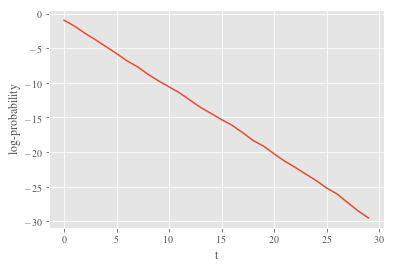

In [2]:
fk_gp = GaussianProb(a=0., b=1., T=30)
alg = particles.SMC(fk=fk_gp, N=100)
alg.run()

plt.style.use('ggplot')
plt.plot(alg.summaries.logLts)
plt.xlabel('t')
plt.ylabel(r'log-probability');

That was not so hard. However our implementation suffers from several limitations: 

1. The SMC sampler we ran may be quite inefficient when interval $[a,b]$ is small; in that case many particles should get a zero weight at each iteration. 
2. We cannot currently run the SQMC algorithm (the quasi Monte Carlo version of SMC); to do so, we need to specify the Markov kernels $M_t$ in a different way: not as simulators, but as deterministic functions that take as inputs uniform variates (see below). 
 
Let's address the second point: 

In [3]:
class GaussianProb(particles.FeynmanKac):
    du = 1  # dimension of uniform variates
    
    def __init__(self, a=0., b=1., T=10):
        self.a, self.b, self.T = a, b, T

    def M0(self, N):
        return stats.norm.rvs(size=N)

    def M(self, t, xp):
        return stats.norm.rvs(loc=xp, size=xp.shape)
    
    def Gamma0(self, u):
        return stats.norm.ppf(u)
    
    def Gamma(self, t, xp, u):
        return stats.norm.ppf(u, loc=xp)
    
    def logG(self, t, xp, x):
        return np.where((x < self.b) & (x > self.a), 0., -np.inf)   
    
fk_gp = GaussianProb(a=0., b=1., T=30)

We have added: 

* methods `Gamma0` and `Gamma`, which define the deterministic functions $\Gamma_0$ and $\Gamma$ we mentioned above. Mathematically, for $U\sim \mathcal{U}([0,1]^{d_u})$, then $\Gamma_0(U)$ is distributed according to $M_0(dx_0)$, and $\Gamma_t(x_{t-1}, U)$ is distributed according to $M_t(x_{t-1}, dx_t)$. 
* class attribute `du`, i.e. $d_u$, the dimension of the $u$-argument of functions $\Gamma_0$ and $\Gamma_t$. 

We are now able to run both the SMC and the SQMC algorithms that corresponds to the Feyman-Kac model of interest; let's compare their respective performance.  (Recall that function ``multiSMC`` runs several algorithms multiple times,  possibly with varying parameters; here we vary parameter `qmc`, which determines whether we run SMC or SMQC.)

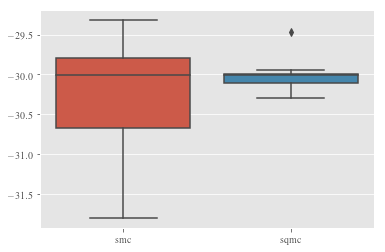

In [5]:
results = particles.multiSMC(fk=fk_gp, qmc={'smc': False, 'sqmc': True}, N=100, nruns=10)

sb.boxplot(x=[r['qmc'] for r in results], y=[r['output'].logLt for r in results]);

We do get some variance reduction, but not so much. Let's see if we can do better by addressing point 1 above.

The considered problem has the structure of a state-space model, where process $(X_t)$ is a random walk, $Y_t = \mathbb{1}_{[a,b]}(X_t)$, and $y_t=1$ for all $t$'s. This remark leads us to define alternative Feynman-Kac models, that would correspond to *guided* and *auxiliary* formalisms of that state-space model. In particular, for the guided filter, the  optimal proposal distribution, i.e. the distribution of $X_t|X_{t-1}, Y_t$, is simply a Gaussian distribution truncated to interval $[a, b]$; let's implement the corresponding Feynman-Kac class. 

In [6]:
def logprobint(a, b, x):
    """ returns log probability that X_t\in[a,b] conditional on X_{t-1}=x
    """
    return np.log(stats.norm.cdf(b - x) - stats.norm.cdf(a - x))

class Guided_GP(GaussianProb):

    def Gamma(self, t, xp, u):
        au = stats.norm.cdf(self.a - xp)
        bu = stats.norm.cdf(self.b - xp)
        return xp + stats.norm.ppf(au + u * (bu - au))

    def Gamma0(self, u):
        return self.Gamma(0, 0., u)

    def M(self, t, xp):
        return self.Gamma(t, xp, stats.uniform.rvs(size=xp.shape))

    def M0(self, N):
        return self.Gamma0(stats.uniform.rvs(size=N))

    def logG(self, t, xp, x):
        if t == 0:
            return np.full(x.shape, logprobint(self.a, self.b, 0.))
        else:
            return logprobint(self.a, self.b, xp)
         
fk_guided = Guided_GP(a=0., b=1., T=30)        

In this particular case, it is a bit more convenient to define methods `Gamma0` and `Gamma` first, and then define methods `M0` and `M`. 

To derive the APF version, we must define the auxiliary functions (functions $\eta_t$ in Chapter 10 of the book) that modify the resampling probabilities; in practice, we define the log of these functions, 
as follows:

In [7]:
class APF_GP(Guided_GP):    
    def logeta(self, t, x):
        return logprobint(self.a, self.b, x)
    
fk_apf = APF_GP(a=0., b=1., T=30)   

Ok, now everything is set! We can do a 3x2 comparison of SMC versus SQMC, for the 3 considered Feynman-Kac models. 

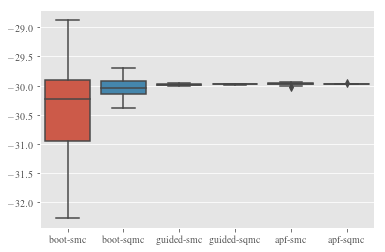

In [8]:
results = particles.multiSMC(fk={'boot':fk_gp, 'guided':fk_guided, 'apf': fk_apf}, 
                          N=100, qmc={'smc': False, 'sqmc': True}, nruns=20)

sb.boxplot(x=['%s-%s'%(r['fk'], r['qmc'])  for r in results], y=[r['output'].logLt for r in results]);

Let's discard the bootstrap algorithms to better visualise the results for the other algorithms:

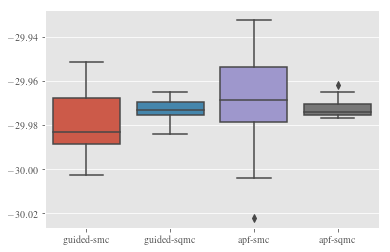

In [9]:
res_noboot = [r for r in results if r['fk']!='boot']
sb.boxplot(x=['%s-%s'%(r['fk'], r['qmc'])  for r in res_noboot], y=[r['output'].logLt for r in res_noboot]);

Voilà!